# Import

In [12]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split, KFold

import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image




%matplotlib inline

# Checking image is correct

In [13]:
# import glob

# data_path = '../../data/caffe_drinks/'
# class_names = os.listdir(data_path)

# for name in class_names:
#     image_list = glob.glob(data_path + name + '/*')
    
#     for image in image_list:
#         img = Image.open(image)
#         img_channel = len(img.split())
        
#         if img_channel != 3:
#             print(image)
    
#     print(name, 'Done')

# Fucntions

In [14]:
def train_test_dataset(dataset, val=False, test_split=0.25):
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
    datasets = {}
    datasets['train'] = torch.utils.data.Subset(dataset, train_idx)
    datasets['test'] = torch.utils.data.Subset(dataset, test_idx)
    
    return datasets

def show_img(data, size=8, shape=(4,2), pred=False):
    images_tensor, labels_tensor = data
    images_tensor, labels_tensor = images_tensor[:size], labels_tensor[:size]
    
    plt.figure(figsize=(10,10))
    row, col = shape
    for i, im in enumerate(images_tensor):
        images_tensor[i] = inv_normalize(im)
        images_numpy = np.array(images_tensor[i].permute(1,2,0))
        class_name = label_to_name[labels_tensor[i].item()]
        
        plt.subplot(row, col, i+1)
        plt.axis('off')
        plt.imshow(images_numpy)
        plt.title(class_name)

# Parameters

In [15]:
EPOCH = 480
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 4
TEST_SIZE = 0.20
LEARNING_RATE = 0.001
MOMENTUM = 0.9

torch.manual_seed(42)

# Datasets
- Dataset : caffe drinks
- Normalized

Name of Class :  ['americano', 'bubbletea_blacksugar', 'cappuccino', 'caramel_macchiato', 'frappuccino_javachip', 'latte_goguma', 'latte_greentea', 'latte_Strawberry', 'mango_juice']
Number of class :  9
Number of Train image :  3459
Number of Test image :  865
Label to Name :  {0: 'americano', 1: 'bubbletea_blacksugar', 2: 'cappuccino', 3: 'caramel_macchiato', 4: 'frappuccino_javachip', 5: 'latte_Strawberry', 6: 'latte_goguma', 7: 'latte_greentea', 8: 'mango_juice'}


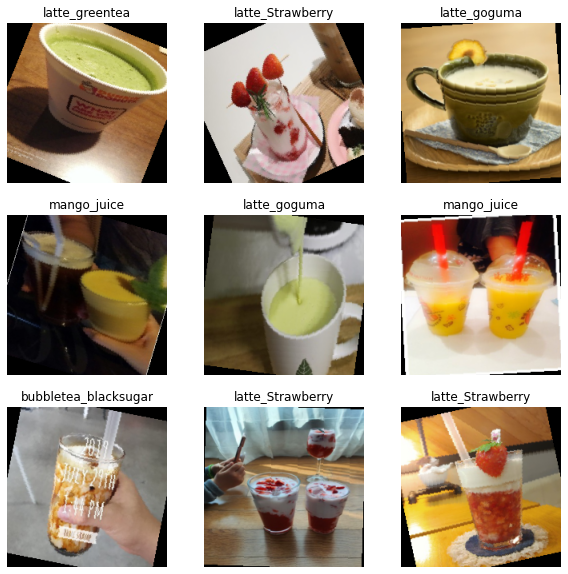

In [16]:
transform = transforms.Compose([
    transforms.Resize((200,200)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

data_path = '../../data/caffe_drinks/'
print('Name of Class : ', os.listdir(data_path))
dataset = torchvision.datasets.ImageFolder(root=data_path, transform=transform)
datasets = train_test_dataset(dataset, test_split=TEST_SIZE)

trainloader = torch.utils.data.DataLoader(datasets['train'], batch_size=TRAIN_BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(datasets['test'], batch_size=TEST_BATCH_SIZE, shuffle=False)

CLASS_NUM = len(os.listdir(data_path))
print('Number of class : ', CLASS_NUM)
print('Number of Train image : ', len(datasets['train']))
print('Number of Test image : ', len(datasets['test']))

label_to_name = {v:k for k,v in dataset.class_to_idx.items()}
print('Label to Name : ', label_to_name)

show_img(iter(trainloader).next(), size=9, shape=(3,3))   

# Model
- VGG16
- Transfer Learning

In [6]:
# # Models
# model_vgg16 = torchvision.models.vgg16(pretrained=True)

# for p in model_vgg16.features.parameters():
#     p.requires_grad = False
    
# model_vgg16.classifier[6] = nn.Linear(4096, CLASS_NUM)
# model_vgg16.classifier

In [17]:
# Models
model = torchvision.models.resnet152(pretrained=True)

for p in model.parameters():
    p.requires_grad = False
    
model.fc = nn.Linear(2048, CLASS_NUM)
model.fc

Linear(in_features=2048, out_features=9, bias=True)

# Set GPU

In [8]:
# GPU 여부
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('We are using GPU')
else:
    device = torch.device('cpu')
    print('We are using CPU')

We are using GPU


In [20]:
device = torch.device('cpu')

# Loss Function & Optimizer

In [18]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.1, last_epoch=-1, verbose=False)

# Model Test
- Checking Code

In [10]:
# Model Test
with torch.no_grad():
    model.eval()
    
    model.to(device)
    ex_img, ex_label = iter(trainloader).next()
    ex_img, ex_label = ex_img.to(device), ex_label.to(device)
    ex_output = model(ex_img)
    
    print(ex_img.size())
    print(ex_output.max(1))

torch.Size([32, 3, 200, 200])
torch.return_types.max(
values=tensor([0.2955, 0.5219, 0.6703, 0.5507, 0.3672, 0.7113, 0.4733, 0.3762, 0.4627,
        0.3271, 0.8293, 0.6748, 0.5373, 0.5462, 0.4136, 0.6397, 0.2952, 0.4536,
        0.8098, 1.0501, 0.5285, 0.5023, 0.7492, 0.5214, 0.5245, 0.4076, 0.6688,
        0.6260, 0.8720, 0.8190, 0.3615, 0.4620], device='cuda:0'),
indices=tensor([1, 8, 0, 1, 8, 0, 0, 0, 7, 8, 0, 1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 8, 0, 0, 0, 0, 8, 0], device='cuda:0'))


# Training

In [11]:
import time

print('------------------Start Training------------------')

loss_for_epoch = []
for e in range(EPOCH):
    start_time = time.time()
    
    model.train()
    model.to(device)
    
    running_loss = 0
    for i, data in enumerate(trainloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        running_loss += loss
        now = time.time()
        time_cost = now - start_time
        print('\rEpoch : [%d/%d]----- Iter : [%d/%d] ----- LOSS : %.3f------ Time : %d' 
              %(e+1, EPOCH, i+1, len(trainloader), running_loss, time_cost), end='')
        
    scheduler.step()
    if e == 0:
        print('\nThe Prediction of Total Time : %s' %time.strftime("%H:%M:%S", time.gmtime(time_cost*EPOCH)))
        
    print('\n')
    loss_for_epoch.append(running_loss)
print('------------------Finish Training------------------')

------------------Start Training------------------
Epoch : [1/480]----- Iter : [109/109] ----- LOSS : 169.356------ Time : 24
The Prediction of Total Time : 03:15:58


Epoch : [2/480]----- Iter : [109/109] ----- LOSS : 97.817------ Time : 24

Epoch : [3/480]----- Iter : [109/109] ----- LOSS : 77.705------ Time : 24

Epoch : [4/480]----- Iter : [109/109] ----- LOSS : 66.822------ Time : 24

Epoch : [5/480]----- Iter : [109/109] ----- LOSS : 62.032------ Time : 24

Epoch : [6/480]----- Iter : [109/109] ----- LOSS : 58.821------ Time : 24

Epoch : [7/480]----- Iter : [109/109] ----- LOSS : 56.037------ Time : 23

Epoch : [8/480]----- Iter : [109/109] ----- LOSS : 52.365------ Time : 23

Epoch : [9/480]----- Iter : [109/109] ----- LOSS : 49.561------ Time : 23

Epoch : [10/480]----- Iter : [109/109] ----- LOSS : 48.320------ Time : 23

Epoch : [11/480]----- Iter : [109/109] ----- LOSS : 49.214------ Time : 23

Epoch : [12/480]----- Iter : [109/109] ----- LOSS : 49.140------ Time : 23

Epoc

Epoch : [213/480]----- Iter : [109/109] ----- LOSS : 30.440------ Time : 23

Epoch : [214/480]----- Iter : [109/109] ----- LOSS : 31.734------ Time : 23

Epoch : [215/480]----- Iter : [109/109] ----- LOSS : 29.506------ Time : 23

Epoch : [216/480]----- Iter : [109/109] ----- LOSS : 30.699------ Time : 23

Epoch : [217/480]----- Iter : [109/109] ----- LOSS : 30.388------ Time : 23

Epoch : [218/480]----- Iter : [109/109] ----- LOSS : 29.893------ Time : 23

Epoch : [219/480]----- Iter : [109/109] ----- LOSS : 30.511------ Time : 23

Epoch : [220/480]----- Iter : [109/109] ----- LOSS : 30.801------ Time : 23

Epoch : [221/480]----- Iter : [109/109] ----- LOSS : 30.595------ Time : 23

Epoch : [222/480]----- Iter : [109/109] ----- LOSS : 30.235------ Time : 23

Epoch : [223/480]----- Iter : [109/109] ----- LOSS : 31.312------ Time : 23

Epoch : [224/480]----- Iter : [109/109] ----- LOSS : 29.602------ Time : 23

Epoch : [225/480]----- Iter : [109/109] ----- LOSS : 29.398------ Time : 23


Epoch : [425/480]----- Iter : [109/109] ----- LOSS : 29.910------ Time : 23

Epoch : [426/480]----- Iter : [109/109] ----- LOSS : 29.690------ Time : 23

Epoch : [427/480]----- Iter : [109/109] ----- LOSS : 30.068------ Time : 23

Epoch : [428/480]----- Iter : [109/109] ----- LOSS : 28.688------ Time : 23

Epoch : [429/480]----- Iter : [109/109] ----- LOSS : 33.643------ Time : 23

Epoch : [430/480]----- Iter : [109/109] ----- LOSS : 30.134------ Time : 23

Epoch : [431/480]----- Iter : [109/109] ----- LOSS : 32.184------ Time : 23

Epoch : [432/480]----- Iter : [109/109] ----- LOSS : 31.385------ Time : 23

Epoch : [433/480]----- Iter : [109/109] ----- LOSS : 30.279------ Time : 23

Epoch : [434/480]----- Iter : [109/109] ----- LOSS : 29.605------ Time : 23

Epoch : [435/480]----- Iter : [109/109] ----- LOSS : 30.929------ Time : 23

Epoch : [436/480]----- Iter : [109/109] ----- LOSS : 30.570------ Time : 23

Epoch : [437/480]----- Iter : [109/109] ----- LOSS : 31.091------ Time : 23


# Test

In [12]:
correct = 0
total = 0
model.eval()

with torch.no_grad():
    model.to(device)
    for i, data in enumerate(testloader):
        test_images, test_labels = data
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        
        test_outputs = model(test_images)
        pred = test_outputs.argmax(dim=1, keepdim=True)
        total += pred.size()[0]
        correct += pred.eq(test_labels.view_as(pred)).sum().item()

acc = correct / total * 100
print('The Accuracy of Model is %0.2f%%' % (correct / total * 100))

The Accuracy of Model is 89.71%


# Save Model

In [13]:
# Save Model
MODEL_NAME = 'resnet151'
torch.save(model.cpu().state_dict(), os.getcwd() + '/weights/trained_model_{}_epoch{}_acc{}_class{}.pth'.format(MODEL_NAME, EPOCH, acc, CLASS_NUM))

['latte_goguma', 'latte_Strawberry', 'mango_juice', 'frappuccino_javachip']


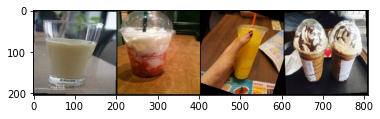

In [14]:
model.eval()
with torch.no_grad():
    ex_img, ex_label = iter(testloader).next()
    model.to(device)
    ex_img = ex_img.to(device)
    output = model(ex_img)
    ex_img = ex_img.to('cpu')
ex_pred = output.argmax(axis=1)

from torchvision.utils import make_grid

for i, im in enumerate(ex_img):
    ex_img[i] = inv_normalize(ex_img[i])
img_grid = make_grid(ex_img).permute(1,2,0)
plt.imshow(img_grid)
output_name = [label_to_name[a.item()] for a in ex_label]
print(output_name)

In [21]:
confusion_matrix = torch.zeros(CLASS_NUM, CLASS_NUM)
miss_images, miss_gts, miss_preds = [], [], []
with torch.no_grad():
    model.to(device)
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        mask = (preds == classes)
        miss_images.append(inputs[mask])
        miss_gts.append(classes[mask])
        miss_preds.append(preds[mask])

        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
result = confusion_matrix.diag()/confusion_matrix.sum(1)

print('--------Accuracy of Each Class--------')
for name, acc in zip(label_to_name.values(), result):
    print('%s : %0.2f%%' %(name, acc * 100))

tensor([[ 6., 30.,  5.,  2.,  0.,  0., 45.,  0.,  8.],
        [10., 12.,  3.,  0.,  0.,  0., 58.,  0.,  3.],
        [ 8.,  7.,  1.,  3.,  0.,  2., 67.,  0., 12.],
        [10., 18.,  2.,  2.,  0.,  0., 68.,  0.,  3.],
        [19.,  6.,  0.,  0.,  0.,  1., 60.,  0.,  1.],
        [14., 14.,  3.,  1.,  0.,  0., 63.,  0.,  3.],
        [ 9., 22.,  7.,  0.,  0.,  0., 56.,  0.,  6.],
        [ 5., 24.,  4.,  0.,  0.,  0., 63.,  0.,  6.],
        [16., 22., 10.,  1.,  0.,  0., 38.,  0.,  6.]])
--------Accuracy of Each Class--------
americano : 6.25%
bubbletea_blacksugar : 13.95%
cappuccino : 1.00%
caramel_macchiato : 1.94%
frappuccino_javachip : 0.00%
latte_Strawberry : 0.00%
latte_goguma : 56.00%
latte_greentea : 0.00%
mango_juice : 6.45%


In [22]:
classes

tensor([5])

In [27]:
t.long()

tensor(5)

In [23]:
preds

tensor([6])

In [7]:
print(confusion_matrix)

NameError: name 'confusion_matrix' is not defined

In [218]:
_, a=  torch.max(output, 1)

In [236]:
torch.stack(miss_images, 0)

RuntimeError: stack expects each tensor to be equal size, but got [3, 3, 200, 200] at entry 0 and [4, 3, 200, 200] at entry 1

In [239]:
b = torch.Tensor([len(miss_images), 3, 200, 200])
torch.cat(miss_images, out=b).shape

torch.Size([788, 3, 200, 200])

In [ ]:
torch.Tensor_l

In [181]:
label_to_name

{0: 'americano',
 1: 'bubbletea_blacksugar',
 2: 'cappuccino',
 3: 'caramel_macchiato',
 4: 'frappuccino_javachip',
 5: 'latte_Strawberry',
 6: 'latte_goguma',
 7: 'latte_greentea',
 8: 'mango_juice'}

In [194]:
with torch.no_grad():
    model.eval()
    model.to(device)
    
    test_img, test_label = iter(testloader).next()
    test_img = test_img.to(device)
    test_label = test_label.to(device)
    output_test = model(test_img)
    prediction_label = output_test.argmax(1)
    print('Prediction : ', prediction_label)
    print('Ground Truth : ', test_label)

Prediction :  tensor([4, 5, 1, 2], device='cuda:0')
Ground Truth :  tensor([4, 5, 1, 3], device='cuda:0')


In [184]:
torch.where(prediction_label == 6, 
           torch.where(prediction_label != test_label, 1, prediction_label), prediction_label)

tensor([1, 5, 1, 3], device='cuda:0')

In [204]:
gt = torch.Tensor([3,4,5,6])
pred = torch.Tensor([3,4,4,6])

In [211]:
torch.where(gt != 5., gt, 
           torch.where(gt != pred, 1., 0.))

tensor([3., 4., 1., 6.])

In [ ]:
miss_prediction = (test_label != prediction_label) and ()
miss_prediction

In [16]:
import pandas as pd

def highlight_diag(df):
    a = np.full(df.shape, '', dtype='<U24')
    np.fill_diagonal(a, 'background-color: yellow')
    return pd.DataFrame(a, index=df.index, columns=df.columns)

df = pd.DataFrame(
    data = np.array(confusion_matrix).astype(np.int8),
    columns=label_to_name.values(),
    index=label_to_name.values()
)
df = df.append(df.sum(numeric_only=True), ignore_index=True)
df.index = list(label_to_name.values()) + ['Total']
df.style.apply(highlight_diag, axis=None)

,americano,bubbletea_blacksugar,cappuccino,caramel_macchiato,frappuccino_javachip,latte_Strawberry,latte_goguma,latte_greentea,mango_juice
americano,89,1,3,2,2,0,1,1,0
bubbletea_blacksugar,0,67,0,3,3,1,0,0,0
cappuccino,4,1,79,5,1,0,12,0,0
caramel_macchiato,1,5,3,76,2,0,6,0,2
frappuccino_javachip,1,2,0,5,87,0,0,0,0
latte_Strawberry,0,3,0,0,1,91,0,0,3
latte_goguma,1,0,13,6,1,0,68,6,1
latte_greentea,1,0,0,1,0,0,4,87,0
mango_juice,0,2,0,0,0,0,0,1,110
Total,97,81,98,98,97,92,91,95,116


,americano,bubbletea_blacksugar,cappuccino,caramel_macchiato,frappuccino_javachip,latte_Strawberry,latte_goguma,latte_greentea,mango_juice
americano,89,1,3,2,2,0,1,1,0
bubbletea_blacksugar,0,67,0,3,3,1,0,0,0
cappuccino,4,1,79,5,1,0,12,0,0
caramel_macchiato,1,5,3,76,2,0,6,0,2
frappuccino_javachip,1,2,0,5,87,0,0,0,0
latte_Strawberry,0,3,0,0,1,91,0,0,3
latte_goguma,1,0,13,6,1,0,68,6,1
latte_greentea,1,0,0,1,0,0,4,87,0
mango_juice,0,2,0,0,0,0,0,1,110
Total,97,81,98,98,97,92,91,95,116


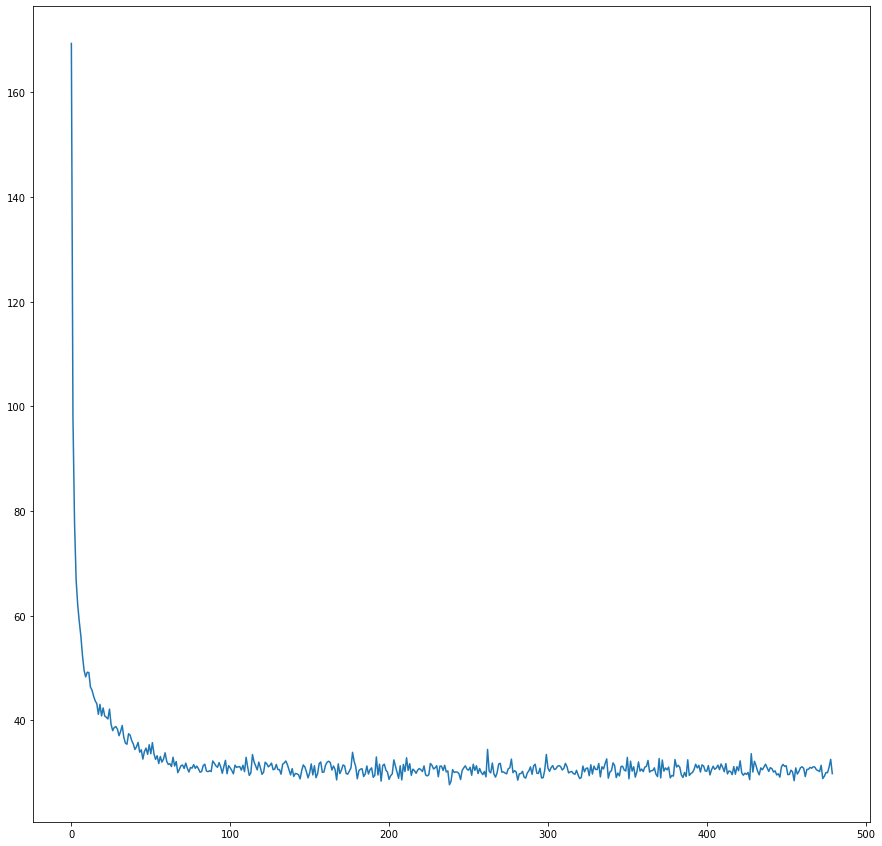

In [17]:
plt.figure(figsize=(15,15))
plt.plot(loss_for_epoch)